In [1]:
# Hierarchical Bayes

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pymc3 as pm
import theano

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\demo\desktop\cpsc540\cpsc540-env\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import data
# datafile = "../active_data/WHO_country.csv"
# populationFile = "../active_data/population.csv"
datafile = "csse_world_normalized_6.csv"
df = pd.read_csv(datafile)
# population = pd.read_csv(populationFile)

countryIdx = df.CountryCode.values
countyNames = df.Country.unique()
nCountries = len(df.Country.unique())

In [20]:
countryIdx = []
country = []
date = []
confirmed = []

testCountryIdx = []
testCountry = []
testDate = []
testConfirmed = []

firstDayEachCountry = []
for row in df.values:
    countryId = row[0]
    countryName = row[1]
    firstDay = 1
    for day in range(2, np.size(row)-5):
        if (row[day] == 0):
            firstDay += 1
        # The first time that the country had confirmed cases. 
        else:
            countryIdx.append(countryId)
            country.append(countryName)
            date.append(day-firstDay)
#             #Test normalization, divided by the previous day confirmed case
#             if (type(row[day-1])!=int or row[day-1] == 0):
#                 confirmed.append(row[day]/row[day])
#             elif (row[day-1] > 0):
#                 confirmed.append(row[day]/row[day-1])
            confirmed.append(row[day])
    for day in range(np.size(row)-5, np.size(row)):
        if (row[day] == 0):
            firstDay += 1
        # The first time that the country had confirmed cases. 
        else:
            testCountryIdx.append(countryId)
            testCountry.append(countryName)
            testDate.append(day-firstDay)
#             #Test normalization, divided by the previous day confirmed case
#             if (type(row[day-1])!=int or row[day-1] == 0):
#                 confirmed.append(row[day]/row[day])
#             elif (row[day-1] > 0):
#                 confirmed.append(row[day]/row[day-1])
            testConfirmed.append(row[day])
    firstDayEachCountry.append(firstDay)
            
# print(firstDayEachCountry)

trainingData = pd.DataFrame({"countryIdx": countryIdx,"country":country, "day": date, "confirmed":confirmed})
# trainingData = trainingData.sample(frac=1)
testingData = pd.DataFrame({"countryIdx": testCountryIdx,"country":testCountry, "day": testDate, "confirmed":testConfirmed})
# [trainingData, testingData] = np.array_split(shuffledData, 2)
trainingData
testingData

,countryIdx,country,day,confirmed
0,0,Taiwan*,80,16.039112
1,0,Taiwan*,81,16.165074
2,0,Taiwan*,82,16.291035
3,0,Taiwan*,83,16.500971
4,0,Taiwan*,84,16.500971
5,1,"Korea, South",80,405.371541
6,1,"Korea, South",81,406.535287
7,1,"Korea, South",82,407.776617
8,1,"Korea, South",83,408.746405
9,1,"Korea, South",84,409.793776


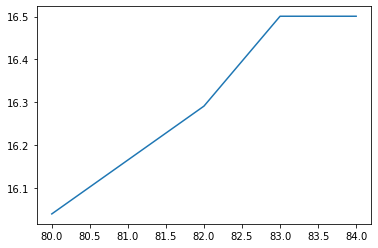

In [4]:
plt.plot(testingData.day.values[0:5],testingData.confirmed.values[0:5])

In [11]:
countyIdx = trainingData.countryIdx.values
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)
    mu_c = pm.Normal('mu_c', mu=0., sigma=100)
    sigma_c = pm.HalfNormal('sigma_c', 5.)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=nCountries)
    # Intercept for each county, distributed around group mean mu_a
    
    # Enforce b to be negative
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    b = BoundedNormal('b', mu=mu_b, sigma=sigma_b, shape=nCountries)
    
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=nCountries)

    # Model error
    eps = pm.HalfCauchy('eps', 5.)

#     radon_est = a[countyIdx] + b[countyIdx]*trainingData.day.values
    confirmedEst = a[countyIdx] /(1+ np.exp(-b[countyIdx]*(trainingData.day.values - c[countyIdx])))
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=confirmedEst,
                           sigma=eps, observed=trainingData.confirmed)

In [12]:
#Load the model 
with hierarchical_model:
    hierarchical_trace = pm.load_trace("csse_world_normalized_6.csv.model")

In [13]:
#Let's calculate test RMSD
N = testingData.shape[0]
RMSD = 0.0
for index, row in testingData.iterrows():
    z = row["countryIdx"]
    x = row["day"]
    y_actual = row["confirmed"]
    a_val = hierarchical_trace['a'][z][z]
    b_val = hierarchical_trace['b'][z][z]
    y_predict = a_val + b_val * x
        
    RMSD += (y_actual-y_predict)**2
    
RMSD = RMSD/N
RMSD = math.sqrt(RMSD)
print(RMSD)

748.3587996790995


In [14]:
#Let's calculate train RMSD
N = trainingData.shape[0]
RMSD = 0.0
for index, row in trainingData.iterrows():
    z = row["countryIdx"]
    x = row["day"]
    y_actual = row["confirmed"]
    a_val = hierarchical_trace['a'][z][z]
    b_val = hierarchical_trace['b'][z][z]
    y_predict = a_val + b_val * x
        
    RMSD += (y_actual-y_predict)**2
    
RMSD = RMSD/N
RMSD = math.sqrt(RMSD)
print(RMSD)

1412.9283355622383


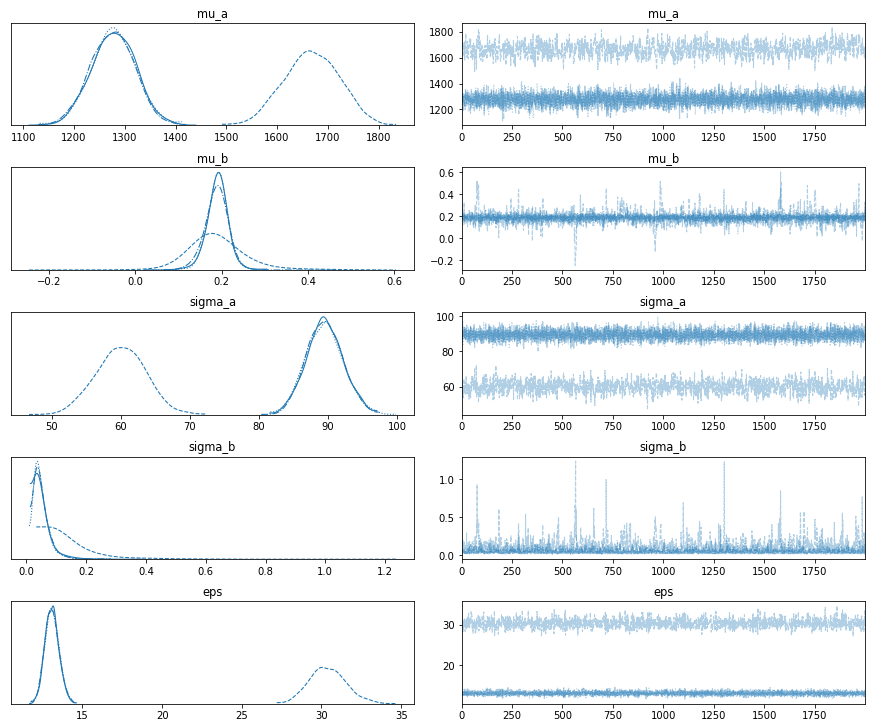

In [15]:
pm.traceplot(hierarchical_trace,
             var_names=['mu_a', 'mu_b',
                        'sigma_a', 'sigma_b',
                        'eps']);

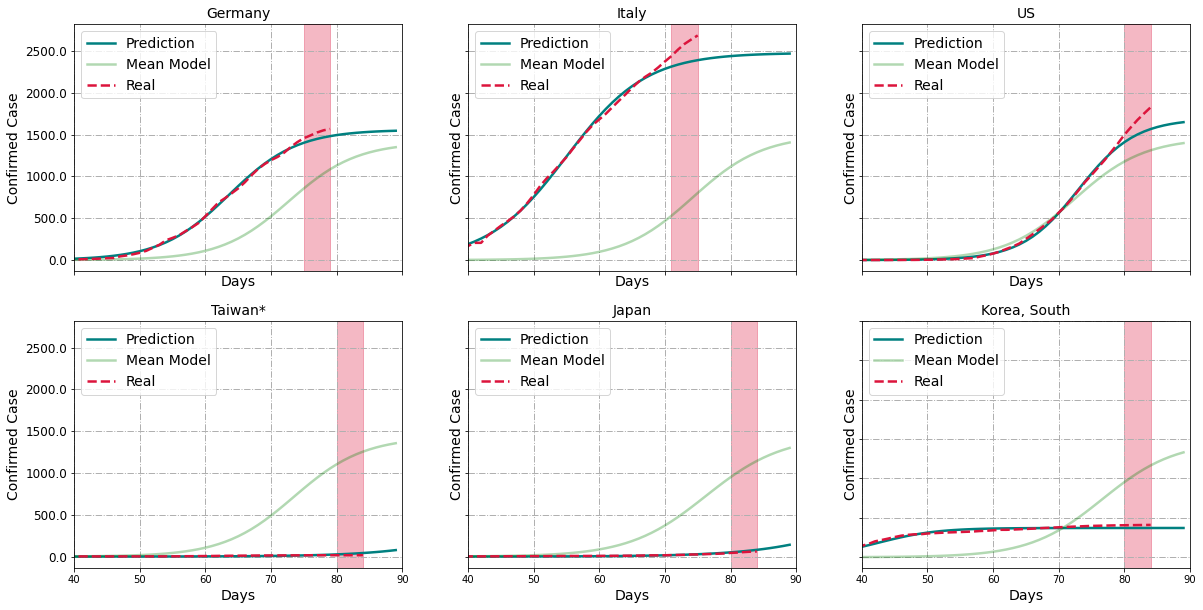

In [83]:
# selection = ['Taiwan', 'Korea, South','Japan','Italy', 'Germany', 'US']
selection = ['Germany','Italy', 'US', 'Taiwan*','Japan', 'Korea, South']
fig, axis = plt.subplots(2, 3, figsize=(20, 10), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = trainingData[trainingData.country == c]
    d_data = testingData[testingData.country == c]
    

    c_data = c_data.reset_index(drop=True)
    c_index = np.where(countyNames == c)[0][0]
    z = list(c_data['countryIdx'])[0]
    
    xvals = np.linspace(1, 89, num=89)
    
    a_val = hierarchical_trace['a'][z][z]
    b_val = hierarchical_trace['b'][z][z]
    c_val = hierarchical_trace['c'][z][z]

    lw = 2.5
    fontsize = 14
    
    axis[i].plot(xvals, a_val /(1+ np.exp(-b_val*(xvals - c_val))), 'teal', label='Prediction', lw=lw)
        
#     for a_val, b_val, c_val in zip(hierarchical_trace['a'][z], hierarchical_trace['b'][z], hierarchical_trace['c'][z]):
#         axis[i].plot(xvals, a_val /(1+ np.exp(-b_val*(xvals - c_val))), 'g', alpha=.3)
    axis[i].plot(xvals, hierarchical_trace['a'][z].mean() /(1+ np.exp(-hierarchical_trace['b'][z].mean()*(xvals - hierarchical_trace['c'][z].mean()))),
                 'g', alpha=0.3, lw=lw, label='Mean Model')
    axis[i].plot(c_data.day.append(d_data.day), c_data.confirmed.append(d_data.confirmed),
                    alpha=1, color='crimson',linestyle='dashed', linewidth=lw, label='Real')
#     axis[i].plot(d_data.day, d_data.confirmed,
#                 alpha=1, color='r',linestyle='dashed')
    
    axis[i].axvspan(min(d_data.day), max(d_data.day), color='crimson', alpha=0.3)
#     axis[i].set_xticks([0, 1])
#     axis[i].set_ylim(-1, 4)
    axis[i].set_title(c, fontsize=fontsize)
    axis[i].grid(linestyle='-.', linewidth=1)

    axis[i].legend(fontsize=fontsize)
    axis[i].set_ylabel('Confirmed Case', fontsize=fontsize)
    axis[i].set_xlabel('Days', fontsize=fontsize)

    axis[i].set_xlim([40,90])
    
    axis[i].set_yticks(np.linspace(0, 3000, num=7)) 
    axis[i].set_yticklabels(np.linspace(0, 3000, num=7), fontsize=12)

plt.savefig("plot.png")


In [89]:
#Let's calculate test RMSD
N = testingData.shape[0]
RMSD = np.array([0.0] * 6)

for index, row in testingData.iterrows():
    z = row["countryIdx"]
    x = row["day"]
    y_actual = row["confirmed"]
    a_val = hierarchical_trace['a'][z][z]
    b_val = hierarchical_trace['b'][z][z]
    c_val = hierarchical_trace['c'][z][z]
    y_predict = a_val /(1+ np.exp(-b_val*(x - c_val)))
    RMSD[z] += (y_actual-y_predict)**2
    
RMSD = RMSD/5
RMSD = np.sqrt(RMSD)
print(RMSD)
print(np.mean(RMSD))

[ 18.28272333  37.04263303  12.87462555 226.22105918  73.90358965
 184.28588697]
92.1017529524479
